In [1]:
import os
import pickle
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib import colors as cc 
import oLIMpus.analysis as a 
from matplotlib.colors import LogNorm
import matplotlib.cm as cm

from oLIMpus import CoevalBox_T21reionization, CoevalBox_percell

In [10]:
def get_box_slices(z, Lbox, Nbox, OIII_model, ClassyC):

    box_slices = []    

    vmin = []
    vmax = []
    cmap = []
    title = []

    _islice = 0

    box_T21 = CoevalBox_T21reionization(OIII_model.zeus_coeff,OIII_model.zeus_corr, OIII_model.zeus_pk,OIII_model.AP, OIII_model.CP, ClassyC,OIII_model.HMFcl,z,Lbox,Nbox)

    box_OIII = CoevalBox_percell(OIII_model.LIM_coeff,OIII_model.LIM_corr,OIII_model.LIM_pk,OIII_model.zeus_coeff, OIII_model.LP,OIII_model.AP,OIII_model.CP,OIII_model.HMFcl,z,1.,Lbox,Nbox)

    coeval_slice_density = box_OIII.density_box[_islice]
    coeval_slice_SFRD = box_OIII.SFRD_box[_islice]
    coeval_slice_xHI = box_T21.xH_box[_islice]
    coeval_slice_T21 = box_T21.T21_map[_islice]
    coeval_slice_LIM_noiseless = box_OIII.Inu_box_noiseless[_islice]
    coeval_slice_LIM = box_OIII.Inu_box[_islice]
    
    ### DENSITY 
    box_slices.append(coeval_slice_density)
    cmap.append('magma')
    title.append(r'$\delta$')
    vmin.append(-0.6)
    vmax.append(0.6)

    ### SFRD
    box_slices.append(coeval_slice_SFRD)
    cmap.append('bwr')
    title.append(r'${\rm SFRD}\,[M_\odot/{\rm yr}/{\rm Mpc^3}]$')
    vmin.append(1e-3)
    vmax.append(1e0)

    ### XHI
    box_slices.append(coeval_slice_xHI)
    cmap.append('gray')
    title.append(r'$x_{\rm HI}$')
    vmin.append(0)
    vmax.append(1)

    ### T21
    min_value = -10
    max_value = 30
    mid_point = abs(min_value)/(abs(min_value)+abs(max_value))
    colors_list = [(0, 'cyan'),
                (mid_point/1.5, 'blue'),
                (mid_point, "black"),
                ((1.+mid_point)/2.2, 'red'),
                (1, 'yellow')]
    eor_colour = cc.LinearSegmentedColormap.from_list("eor_colour",colors_list)

    box_slices.append(coeval_slice_T21)
    cmap.append(eor_colour)
    title.append(r'$T_{21}\,[{\rm mK}]$')
    vmin.append(min_value)
    vmax.append(max_value)

    vmax_OIII = 7.
    vmax_Ha = 9.

    ### LIM 1 

    summer_cmap = cm.summer
    colors_list = [(0, "black"),
        (0.1, summer_cmap(0)),    
        (0.2, summer_cmap(50)),
        (0.5, summer_cmap(150)),
        (1, summer_cmap(255))]     

    LIM_colour_1 = cc.LinearSegmentedColormap.from_list("LIM_colour_1",colors_list)

    box_slices.append(coeval_slice_LIM_noiseless)
    cmap.append(LIM_colour_1)
    title.append(r'$I_{\rm %s}\,[{\rm Jy/sr}]$'%OIII_model.LP.LINE) 
    vmin.append(0.)
    vmax.append(vmax_OIII+5)

    ### LIM2
    box_slices.append(coeval_slice_LIM)
    cmap.append(LIM_colour_1)
    title.append(r'$I_{\rm %s}+{\rm shot\, noise}$'%OIII_model.LP.LINE) 
    vmin.append(0.)
    vmax.append(vmax_OIII+25)
    
    return box_slices, cmap, title, vmin, vmax


In [11]:
ClassyC = a.runclass(a.Cosmo_Parameters_Input(**a.CosmoParams_input_fid))
OIII_model = a.run_oLIMpus('OIII',LINE_MODEL = 'Yang24', _R = 1., shot_noise= True, quadratic_lognormal=True, astromodel=0, ZMIN=5., RSD_MODE=0)


 80%|████████  | 8/10 [00:01<00:00,  7.87it/s]


SUCCESS: BMF converged in 8 iterations.


100%|██████████| 99/99 [00:08<00:00, 11.80it/s]


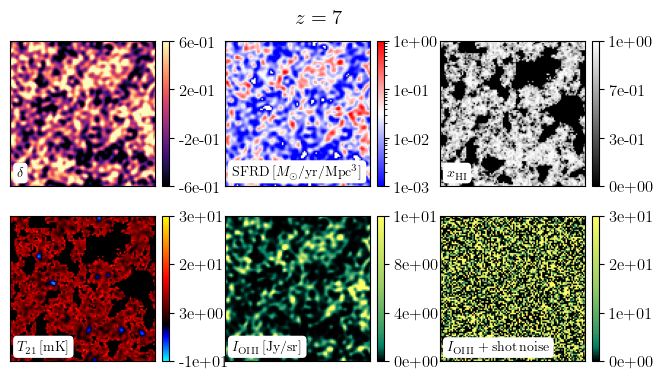

In [12]:
Lbox_fid = 100 

box_slices, cmap, title, vmin_use, vmax_use = get_box_slices(7., Lbox_fid, 100, OIII_model, ClassyC)

im = []
cbar = []
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(7, 4))
subpl = [(0,0),(0,1),(0,2),(1,0),(1,1),(1,2)]

for j in range(len(box_slices)):

    if cmap[j] == 'bwr':
        im = ax[subpl[j]].imshow(box_slices[j],extent=(0,Lbox_fid,0,Lbox_fid),cmap=cmap[j],norm = LogNorm(vmin=vmin_use[j], vmax=vmax_use[j]))

    else:
        im = ax[subpl[j]].imshow(box_slices[j],extent=(0,Lbox_fid,0,Lbox_fid),cmap=cmap[j],vmax =vmax_use[j], vmin = vmin_use[j])
    cbar = fig.colorbar(im, ax=ax[subpl[j]], fraction=0.046, pad=0.04, format="%.0e")

    if cmap[j] == 'bwr':
        xticks = [1e-3, 1e-2, 1e-1,1]  
    else:
        xticks = np.linspace(vmin_use[j],vmax_use[j],4)
    array_ticks = np.vectorize(lambda x: f"{x:.0e}")(xticks)

    cbar.set_ticks(xticks, labels = array_ticks)

    ax[subpl[j]].text(
        0.05, 0.05, title[j], 
        color='black',
        fontsize=10,
        ha='left', va='bottom',
        transform=ax[subpl[j]].transAxes,  
        bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3')  
    )
    ax[subpl[j]].set_xticks([])
    ax[subpl[j]].set_yticks([])

fig.suptitle(r'$z = %g$'%round(7.,1), fontsize=15)
fig.subplots_adjust(left=0.05, right=0.9, top=0.9, bottom=0.1, wspace=0.3)
plt.savefig('./boxes_z7.png',dpi=300)